In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from pathlib import Path
import numpy as np
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

from keras import layers 
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
data_dir = os.path.join('/content/drive/MyDrive/Covid_Radiography_Data/')

train_dir = data_dir + 'train'
validate_dir = data_dir + 'validate'
test_dir = data_dir + 'test'

BATCH_SIZE = 32
IMG_H = 224
IMG_W = 224
num_classes=3

class_subset = sorted(os.listdir(train_dir))
print(class_subset)

['covid', 'normal', 'viral']


In [ ]:
train_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = 0.1
    )

test_aug = ImageDataGenerator(
    rescale = 1./255
    )


train_gen = train_aug.flow_from_directory(
    directory = train_dir,
    batch_size = BATCH_SIZE,                           
    shuffle = True,
    classes = class_subset,
    target_size = (IMG_H, IMG_W),
    class_mode = 'categorical'
    )

validation_gen = train_aug.flow_from_directory(
    directory = validate_dir,
    batch_size=BATCH_SIZE,
    shuffle = True,
    classes = class_subset,
    target_size = (IMG_H, IMG_W),
    class_mode = 'categorical'
    )

test_gen = test_aug.flow_from_directory(
    directory = test_dir,
    shuffle = False,
    target_size = (IMG_H, IMG_W),
    batch_size = 3,
    class_mode = 'categorical'
    )

Found 12127 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

pre_trained_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [ ]:
for layer in pre_trained_model.layers[:14]: #Freeze Layers
    layer.trainable = False

for layer in pre_trained_model.layers[14:]: #Unfreeze Last Layers
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x1 = layers.Flatten()(last_output)
x2 = layers.Dense(512, activation='relu')(x1)
x3 = layers.Dropout(0.5)(x2)
out = layers.Dense(3, activation='softmax')(x3)

model = tf.keras.models.Model(pre_trained_model.input, out)

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)


checkpoint = ModelCheckpoint(filepath = 'tl_model_v1.weights.best.hdf5',
                                  save_best_only = True,
                                  verbose = 1) 

In [ ]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=validation_gen,
                    callbacks = [early_stop, checkpoint]
                         )

Epoch 1/30
379/379 [==============================] - 3750s 10s/step - loss: 0.4899 - accuracy: 0.8079 - val_loss: 0.1918 - val_accuracy: 0.9294

Epoch 00001: val_loss improved from inf to 0.19181, saving model to tl_model_v1.weights.best.hdf5
Epoch 2/30
379/379 [==============================] - 205s 540ms/step - loss: 0.1779 - accuracy: 0.9366 - val_loss: 0.1869 - val_accuracy: 0.9400

Epoch 00002: val_loss improved from 0.19181 to 0.18688, saving model to tl_model_v1.weights.best.hdf5
Epoch 3/30
379/379 [==============================] - 205s 540ms/step - loss: 0.1426 - accuracy: 0.9450 - val_loss: 0.1403 - val_accuracy: 0.9453

Epoch 00003: val_loss improved from 0.18688 to 0.14029, saving model to tl_model_v1.weights.best.hdf5
Epoch 4/30
379/379 [==============================] - 204s 539ms/step - loss: 0.1242 - accuracy: 0.9522 - val_loss: 0.1184 - val_accuracy: 0.9571

Epoch 00004: val_loss improved from 0.14029 to 0.11841, saving model to tl_model_v1.weights.best.hdf5
Epoch 5/3

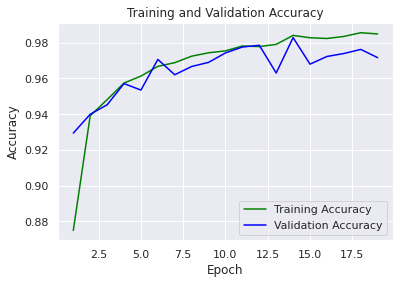

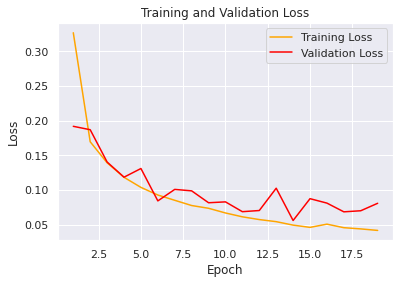

In [ ]:
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='orange', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_gen)

12/12 [==============================] - 11s 852ms/step - loss: 0.0019 - accuracy: 1.0000


[0.0018892695661634207, 1.0]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict(test_gen, 36 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
target_names = ['Covid', 'Normal', 'Viral']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[12  0  0]
 [ 0 12  0]
 [ 0  0 12]]
Classification Report
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00        12
      Normal       1.00      1.00      1.00        12
       Viral       1.00      1.00      1.00        12

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [ ]:
model.save("/content/drive/MyDrive/Models/vgg16_new1.h5")